# Memory & Threads in Conversational Agentic AI Systems in LangGraph

Every interaction between the user and the agentic system is in isolation and a new request without keep track of past historical conversations (by default). By leveraging memory and threads we can make our agentic system conversational.

![](https://i.imgur.com/nJn1o09.png)

#### Memory in LangGraph:

- Utilizes a built-in persistence layer to maintain graph state across executions.
- Enables features like human-in-the-loop interactions, time travel, fault tolerance and conversational capabilities

#### Threads:

- Serve as unique identifiers for sequences of checkpoints (agent state snapshots).
- Allow retrieval and management of graph states post-execution.
- Specified during graph invocation via {"configurable": {"thread_id": "user-session-id"}}.
- User session id can be generated and assigned per unique user or user session
- This is used by the agent to refer to past conversation and agent state history for any user session at any time
- Enables multi-user conversation for your agent


In [0]:
!pip install -q langchain==0.3.14
!pip install -q langchain-openai==0.3.0
!pip install -q langchain-community==0.3.14
!pip install -q langgraph==0.2.64
!pip install -q langgraph-checkpoint-sqlite==2.0.3

## Enter Open AI API Key

In [0]:
# from getpass import getpass

# OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


## Enter Tavily Search API Key

Get a free API key from [here](https://tavily.com/#api)

In [0]:
# TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


In [0]:
import os
# import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
OPENAI_KEY = os.environ['OPENAI_API_KEY']
OPENBB_PAT = os.environ['OPENBB_PAT']
TAVILY_API_KEY = os.environ['TAVILY_API_KEY']

## Setup Environment Variables

In [0]:
# import os

# os.environ['OPENAI_API_KEY'] = OPENAI_KEY
# os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

## State

First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph.

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [0]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

## Augment the LLM with tools

Here we define our custom search tool and then bind it to the LLM to augment the LLM

In [0]:
from langchain_openai import ChatOpenAI
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.tools import tool

llm = ChatOpenAI(model="gpt-4o", temperature=0)

tavily_search = TavilySearchAPIWrapper()
@tool
def search_web(query: str, num_results=5):
    """Search the web for a query. Userful for general information or general news"""
    results = tavily_search.raw_results(query=query,
                                        max_results=num_results,
                                        search_depth='advanced',
                                        include_raw_content=True)
    return results

tools = [search_web]
llm_with_tools = llm.bind_tools(tools=tools)

## Build Agentic Graph with In-Memory Persistence

In [0]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver


# Augmented LLM with Tools Node function
def tool_calling_llm(state: State) -> State:
    current_state = state["messages"]
    return {"messages": [llm_with_tools.invoke(current_state)]}

# Build the graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools=tools))
builder.add_edge(START, "tool_calling_llm")

# Conditional Edge
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from LLM is a tool call -> tools_condition routes to tools
    # If the latest message (result) from LLM is a not a tool call -> tools_condition routes to END
    tools_condition,
    ["tools", END]
)
builder.add_edge("tools", "tool_calling_llm") # this is the key feedback loop
builder.add_edge("tools", END)

# add in-memory persistence (transient memory)
memory = MemorySaver()
agent_inmem = builder.compile(checkpointer=memory)

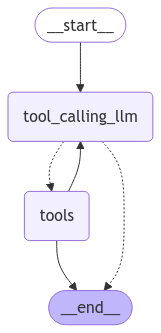

In [0]:
agent_inmem

## Test Agent with In-Memory Persistence

In [0]:
uid = 'user001'
config = {"configurable": {"thread_id": uid}}

In [0]:
user_input = "Explain AI in 1 line"
for event in agent_inmem.stream(input={"messages": user_input},
                          config=config,
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Explain AI in 1 line
================================== Ai Message ==================================

AI, or Artificial Intelligence, is the simulation of human intelligence processes by machines, especially computer systems, to perform tasks that typically require human intelligence, such as visual perception, speech recognition, decision-making, and language translation.


In [0]:
user_input = "Do the same for ML"
for event in agent_inmem.stream(input={"messages": user_input},
                          config=config,
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Do the same for ML
================================== Ai Message ==================================

Machine Learning (ML) is a subset of AI that involves the use of algorithms and statistical models to enable computers to learn from and make predictions or decisions based on data without being explicitly programmed.


In [0]:
agent_inmem.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Explain AI in 1 line', additional_kwargs={}, response_metadata={}, id='e0dff5aa-c699-482e-b115-59ea1ee88315'), AIMessage(content='AI, or Artificial Intelligence, is the simulation of human intelligence processes by machines, especially computer systems, to perform tasks that typically require human intelligence, such as visual perception, speech recognition, decision-making, and language translation.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 71, 'total_tokens': 117, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-90baaadb-213d-43a5-9d8e-66aa8dfd8cdb-0', usage_metadata={'input_to

In [0]:
history = list(agent_inmem.get_state_history(config))
history

[StateSnapshot(values={'messages': [HumanMessage(content='Explain AI in 1 line', additional_kwargs={}, response_metadata={}, id='e0dff5aa-c699-482e-b115-59ea1ee88315'), AIMessage(content='AI, or Artificial Intelligence, is the simulation of human intelligence processes by machines, especially computer systems, to perform tasks that typically require human intelligence, such as visual perception, speech recognition, decision-making, and language translation.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 71, 'total_tokens': 117, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-90baaadb-213d-43a5-9d8e-66aa8dfd8cdb-0', usage_metadata={'input_t

In [0]:
uid = 'user002'
config = {"configurable": {"thread_id": uid}}

In [0]:
user_input = "Tell me 3 latest OpenAI product releases"
for event in agent_inmem.stream(input={"messages": user_input},
                          config=config,
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Tell me 3 latest OpenAI product releases
================================== Ai Message ==================================
Tool Calls:
  search_web (call_ZQCgzIMrDmgDqw2yO8vlVgut)
 Call ID: call_ZQCgzIMrDmgDqw2yO8vlVgut
  Args:
    query: latest OpenAI product releases
    num_results: 3
================================= Tool Message =================================
Name: search_web

{"query": "latest OpenAI product releases", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://openai.com/news/product-releases/", "title": "OpenAI Newsroom | Product", "content": "Introducing canvas, a new way to write and code with ChatGPT. Product Oct 3, 2024 · Introducing the Realtime API > Card image.", "score": 0.7099254, "raw_content": "OpenAI Newsroom | Product | OpenAI\nSkip to main content\nLog in\n\nSwitch to\n\nChatGPT(opens in a new window)\nSora(opens in a new window)\n\nAPI 

In [0]:
user_input = "do the same for Meta releases"
for event in agent_inmem.stream(input={"messages": user_input},
                          config=config,
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

do the same for Meta releases
================================== Ai Message ==================================
Tool Calls:
  search_web (call_Uf1Yj51YDlDKLsMCgWhM0FUd)
 Call ID: call_Uf1Yj51YDlDKLsMCgWhM0FUd
  Args:
    query: latest Meta product releases
    num_results: 3
================================= Tool Message =================================
Name: search_web

{"query": "latest Meta product releases", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.theverge.com/24254101/meta-connect-2024-announcements-products", "title": "Meta Connect 2024: the biggest announcements | The Verge", "content": "Meta announced a new Quest 3S VR headset, updates to its Ray-Ban smart glasses, the latest Llama AI model, and a look into the future with its Orion AR glasses. Meta announced a new Quest 3S VR headset, updates to its Ray-Ban smart glasses, the latest Llama AI mod

In [0]:
uid = 'user001'
config = {"configurable": {"thread_id": uid}}
user_input = "what did we discuss so far"
for event in agent_inmem.stream(input={"messages": user_input},
                          config=config,
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

what did we discuss so far
================================== Ai Message ==================================

We discussed brief one-line explanations of Artificial Intelligence (AI) and Machine Learning (ML). AI was described as the simulation of human intelligence processes by machines, while ML was defined as a subset of AI that enables computers to learn from data and make predictions or decisions without explicit programming.


## Build & Test Agentic Graph with On-disk Persistence

In [0]:
# clearing memory database (just for demo, in general should keep it)
!rm memory.db*

rm: cannot remove 'memory.db*': No such file or directory


In [0]:
from langgraph.checkpoint.sqlite import SqliteSaver

def call_conversational_agent(agent_graph, prompt, user_session_id):
    with SqliteSaver.from_conn_string("memory.db") as memory:
        agent_extmem = agent_graph.compile(checkpointer=memory)
        for event in agent_extmem.stream(input={"messages": prompt},
                                         config={"configurable": {"thread_id": user_session_id}},
                                         stream_mode='values'):
            event['messages'][-1].pretty_print()

In [0]:
builder

In [0]:
uid = 'bond007'
prompt = "What is the latest news on Apple? summarize in 3 bullets"
call_conversational_agent(agent_graph=builder,
                          prompt=prompt,
                          user_session_id=uid)

================================ Human Message =================================

What is the latest news on Apple? summarize in 3 bullets
================================== Ai Message ==================================
Tool Calls:
  search_web (call_OioJ13Qf6V9jQyIXmn2VGIho)
 Call ID: call_OioJ13Qf6V9jQyIXmn2VGIho
  Args:
    query: latest news on Apple
    num_results: 3
================================= Tool Message =================================
Name: search_web

{"query": "latest news on Apple", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.nbcnews.com/tech/apple", "title": "Latest on the iPhone, iPad, Macbook, Apple TV, Operating Systems ...", "content": "Apple News: Latest on the iPhone, iPad, Macbook, Apple TV, Operating Systems & More | NBC News NBC News Now Apple Apple Apple Apple and Huawei battle for sales as their new phones launch on the same day in China Apple announces iPhone event for Sept. NBC News Videos Apple shares c

In [0]:
prompt = "What about microsoft?"
call_conversational_agent(agent_graph=builder,
                          prompt=prompt,
                          user_session_id=uid)

================================ Human Message =================================

What about microsoft?
================================== Ai Message ==================================
Tool Calls:
  search_web (call_yuRvDF3jIsoatQGVHdLhohSx)
 Call ID: call_yuRvDF3jIsoatQGVHdLhohSx
  Args:
    query: latest news on Microsoft
    num_results: 3
================================= Tool Message =================================
Name: search_web

{"query": "latest news on Microsoft", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "The Official Microsoft Blog", "url": "https://blogs.microsoft.com/", "content": "AI transformation and the technology driving change\nNov 7, 2023\n|\nCharlotte Yarkoni - President, Commerce + Ecosystems, Cloud & AI\nStartups to access high-performance Azure infrastructure, accelerating AI breakthroughs\nNov 6, 2023\n|\nDouglas Phillips - CVP, Azure Edge + Platform\nHonoring veterans and recognizing their value and contributions at M